# Create Dataset

In [1]:
import torchvision
torchvision.__version__

'0.7.0'

In [2]:

import os
import matplotlib.pylab as plt
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import glob
import numpy as np
torch.manual_seed(0)
%matplotlib inline

In [3]:
path2data = "../data/interim/grasp/"

def _process_bboxes(name):
    '''Create a list with the coordinates of the grasping rectangles. Every 
    element is either x or y of a vertex.'''
    with open(name, 'r') as f:
        bboxes = list(map(
              lambda coordinate: float(coordinate), f.read().strip().split()))
    return bboxes


def create_image_list():
    # Creating a list with all the image paths
    folders = range(1,11)
    folders = ['0'+str(i) if i<10 else '10' for i in folders]
    filenames = []
    for i in folders:
        for name in glob.glob(os.path.join(path2data, i, 'pcd'+i+'*r.png')):
            filenames.append(name)
    return filenames

def load_img_label(filename):    
    label_file = filename[:-5]+'cpos.txt'
    bboxes = _process_bboxes(label_file)
    label = np.array(bboxes)
    label = label.reshape(-1,8)
    label_clean = []        
    for box in label:
        if not np.isnan(box).any():
            label_clean.append(box.tolist())
    label_clean = np.array(label_clean).reshape(-1).tolist()          
    img = Image.open(filename)
    return img,label_clean

def show_img_label(img,label, thickness=2, size=50):  
    img = img.copy()
    plt.figure(figsize=(size, size))
    # draw a plolygon
    draw = ImageDraw.Draw(img) 
    draw.polygon(label[-8:], outline="blue")    
    plt.imshow(np.asarray(img))


In [4]:
class Cornell_Grasp_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.fullPath2img)
      
    def __getitem__(self, idx):
        pass

In [5]:
def __init__(self, path2data, transform=None, trans_params=None):      
    # Creating a list with all the image paths
    folders = range(1,11)
    folders = ['0'+str(i) if i<10 else '10' for i in folders]
    self.fullPath2img = []
    for i in folders:
        for name in glob.glob(os.path.join(path2data, i, 'pcd'+i+'*r.png')):
            self.fullPath2img.append(name)
    self.transform = transform
    self.trans_params=trans_params

In [6]:

def __getitem__(self, idx):
    # load PIL image  
    image, label = load_img_label(self.fullPath2img[idx])
    label = torch.tensor(label)
    # transform to tensor
    if self.transform:
        image,label = self.transform(image,label,self.trans_params)

    return image, label

In [7]:
Cornell_Grasp_dataset.__init__=__init__
Cornell_Grasp_dataset.__getitem__=__getitem__

In [8]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    label = label.view(-1,2)
    # resize image and label
    image_new = TF.resize(image,target_size)
    for i in range(len(label)):
        x, y = label[i]
        label[i][0] = x/w_orig*w_target
        label[i][1] = y/h_orig*h_target     
    label = label.view(-1,8)
    return image_new,label

def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"]) 
    if params["sample_output"]:
        # randoom choose a grasp to be the ground truth      
        index = random.randint(0, len(label) -1)
        label = label[index]  
    image=TF.to_tensor(image)
    return image, label

def collate_fn(batch):
    imgs, labels = list(zip(*batch))
    targets = []
    for i in range(len(labels)):
        label = labels[i]
        target = torch.zeros(label.shape[0], label.shape[1] + 1)
        target[:,0] = i
        target[:, 1:] = label
        targets.append(target)

    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, 

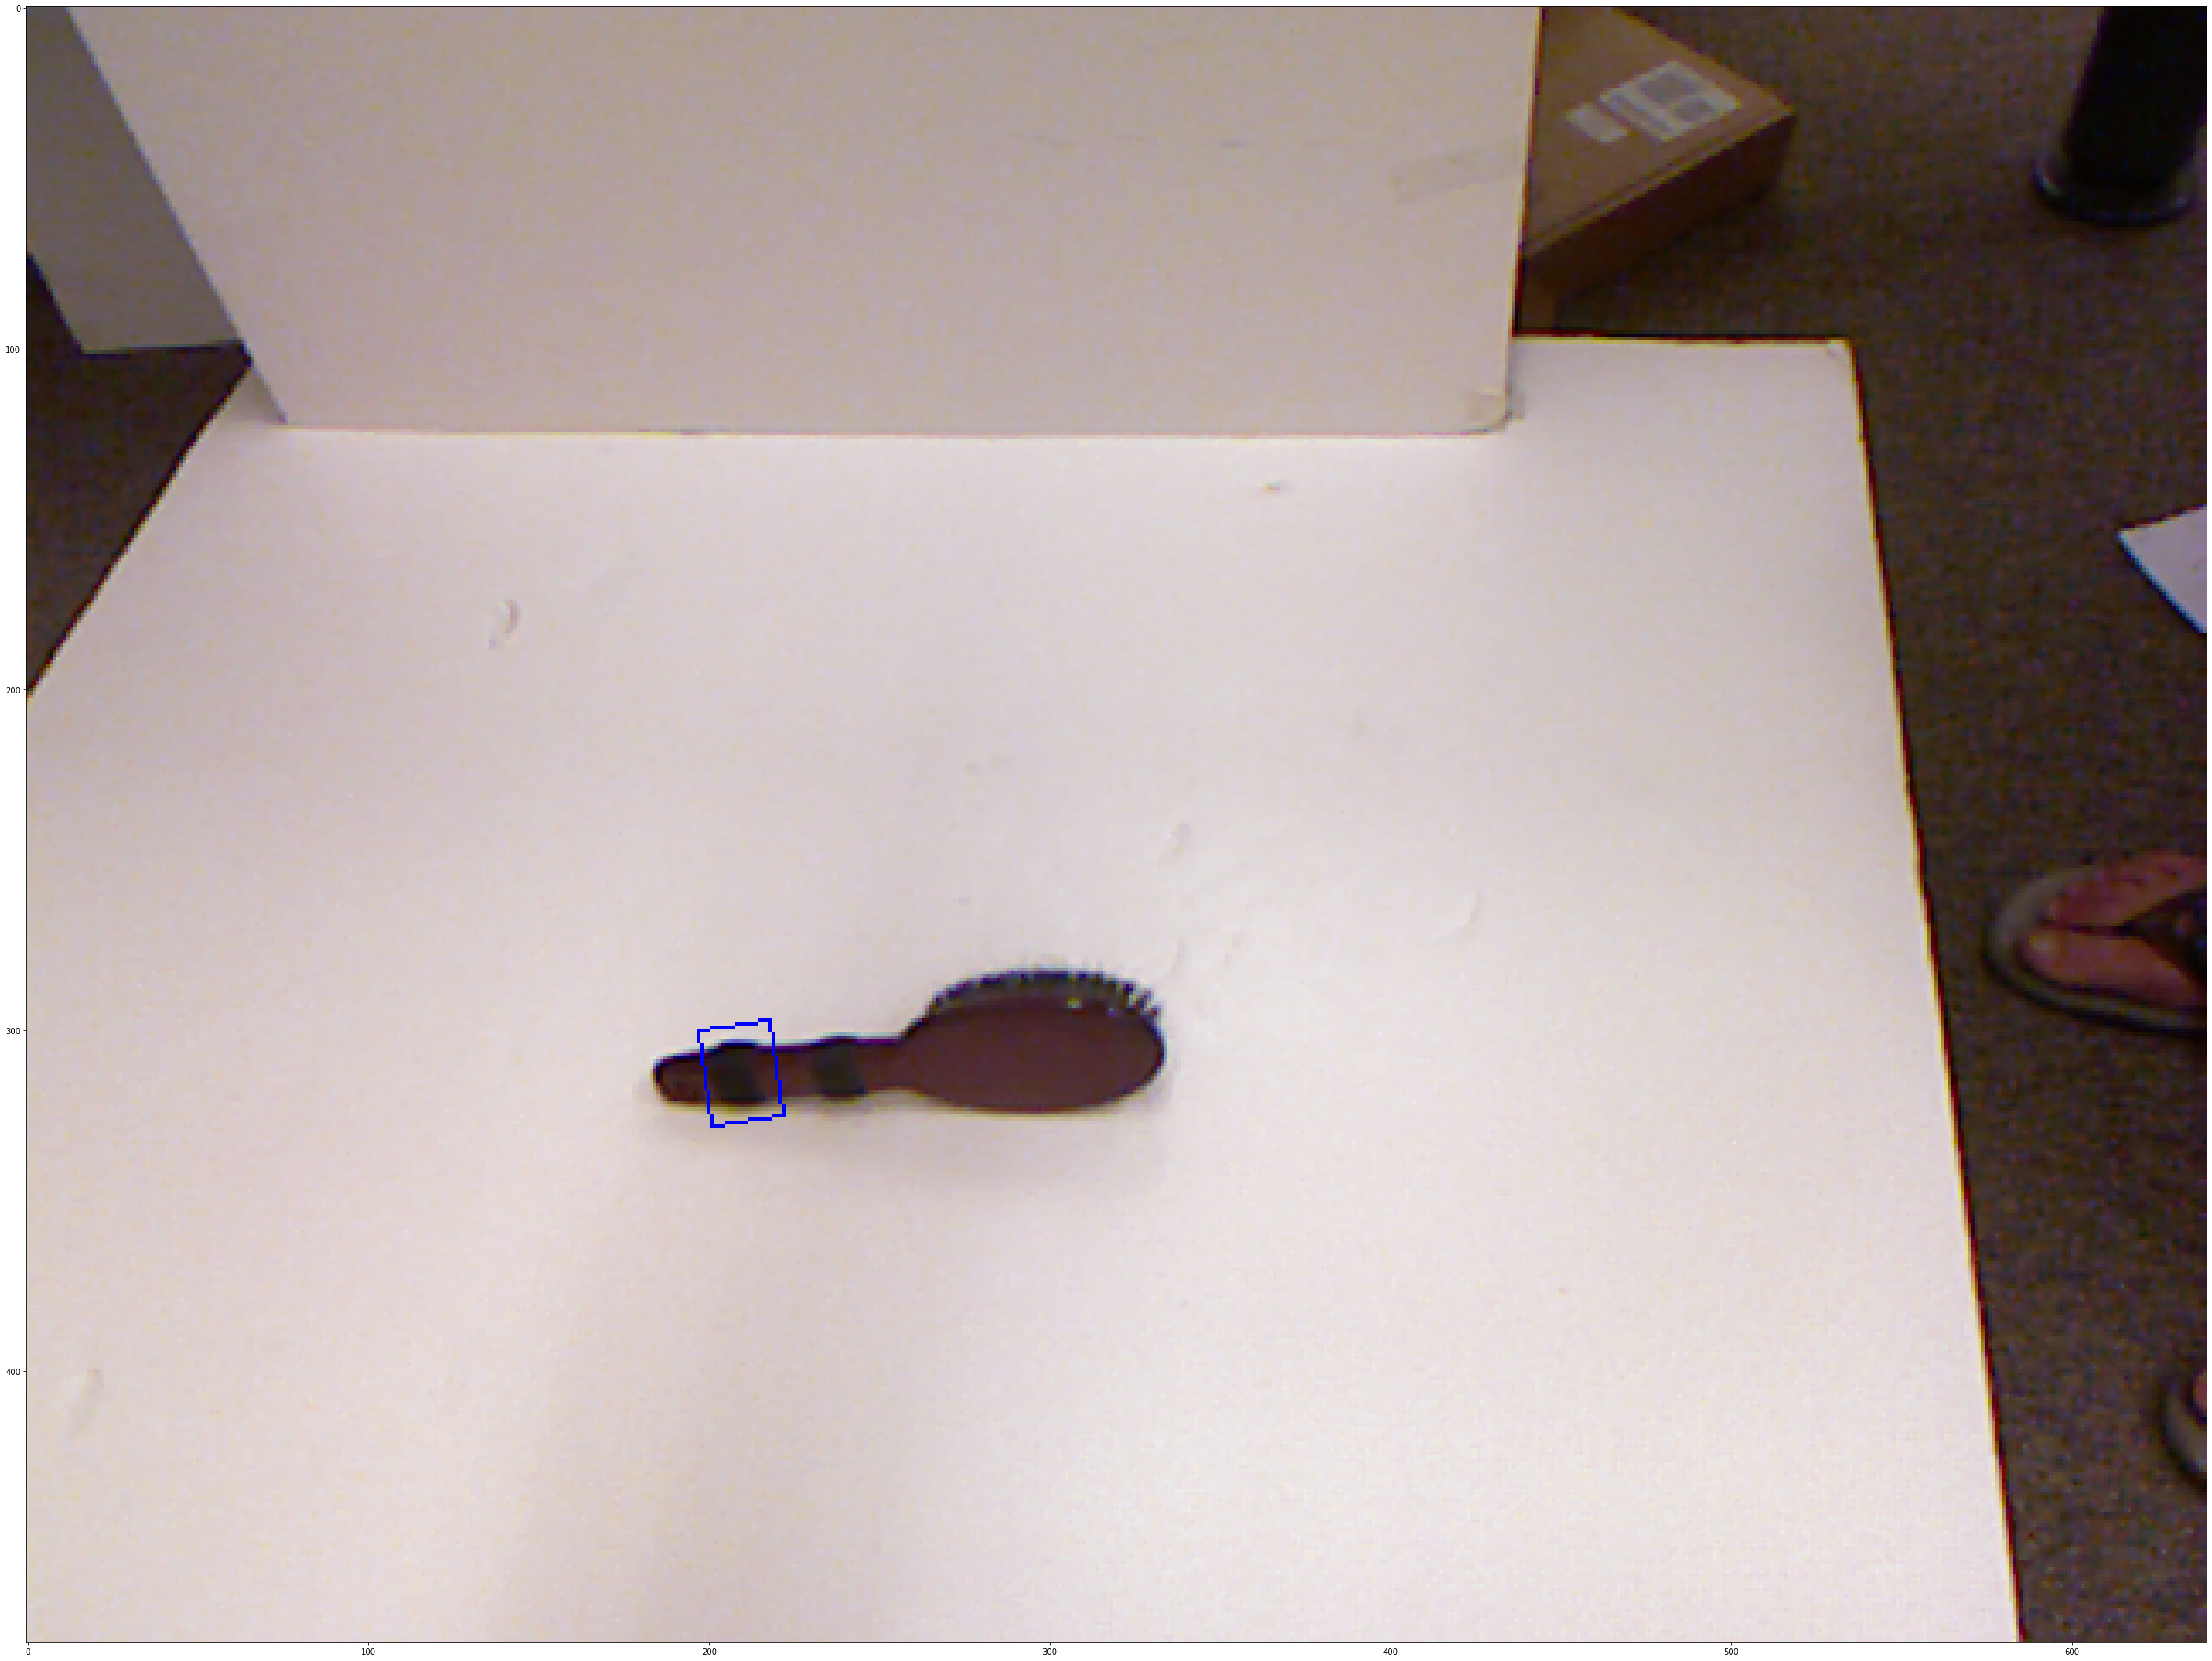

In [9]:
# test transformer
import random
np.random.seed(0)
random.seed(0)

params = {
    "target_size" : (256, 256),
    "sample_output" : True
}

filenames = create_image_list()
f1 = filenames[42]

img, label = load_img_label(f1)

show_img_label(img,label)





tensor([ 87.6000, 157.7525,  88.4000, 176.0000,  96.4000, 175.4667,  95.6000,
        157.2192])


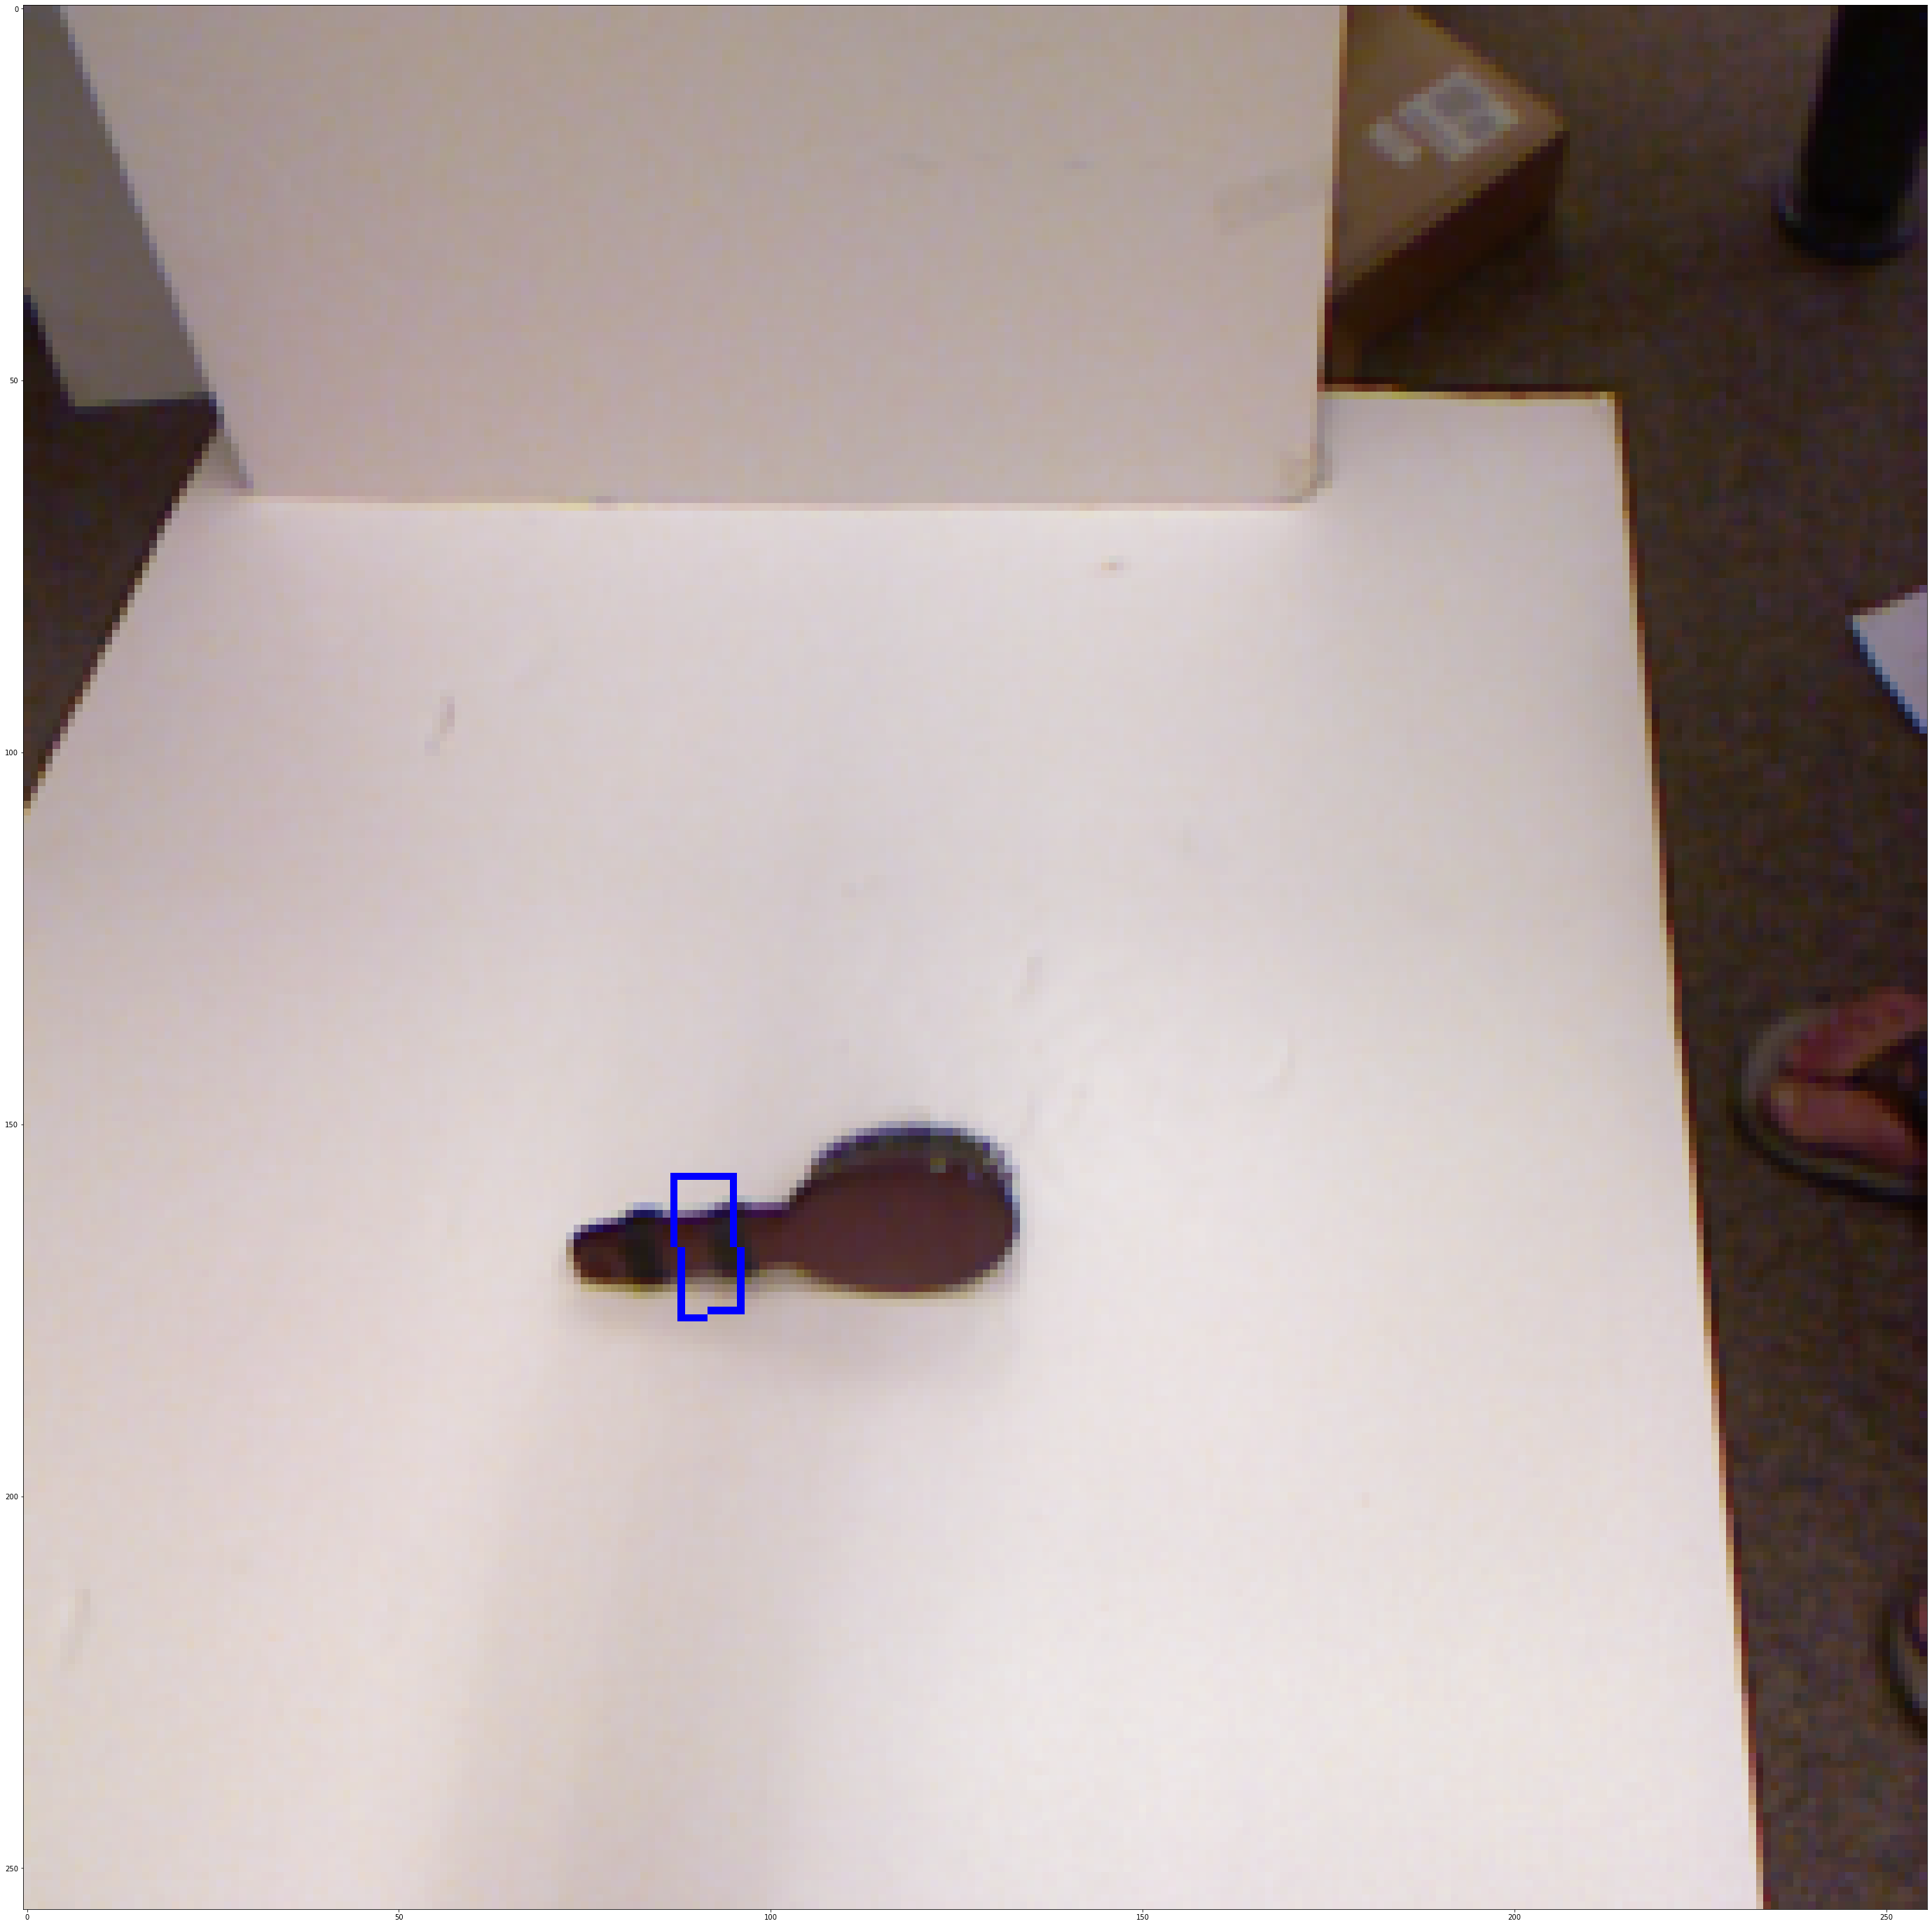

In [10]:
img_t,label_t=transformer(img, torch.tensor(label).view(-1,2),params)

print(label_t)
label_t = torch.squeeze(label_t.view(1,-1)).tolist()

show_img_label(TF.to_pil_image(img_t),label_t)

In [11]:
trans_params_train={
    "target_size" : (256, 256),
    "sample_output" : True
}

In [12]:

trans_params_val={
    "target_size" : (256, 256), 
    "sample_output" : False
}

In [13]:

train_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_train)
val_ds = Cornell_Grasp_dataset(path2data,transformer,trans_params_val)

from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
indices=range(len(train_ds))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))  

619
----------
266


In [14]:
from torch.utils.data import Subset

train_ds = Subset(train_ds,train_index)
print(len(train_ds))

val_ds = Subset(val_ds,val_index)
print(len(val_ds))

619
266


In [15]:

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

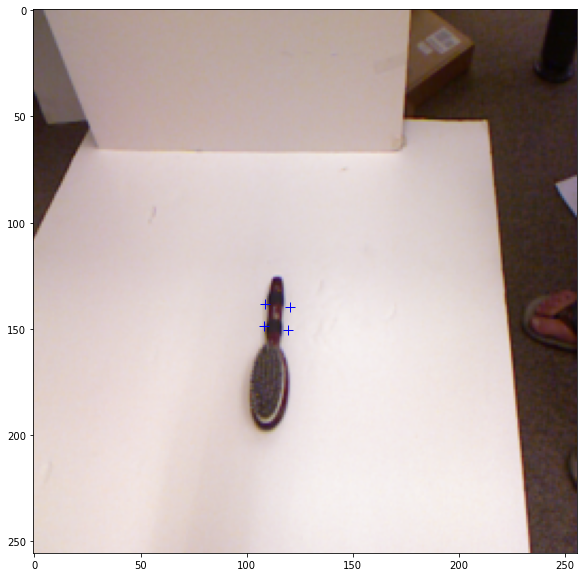

In [16]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

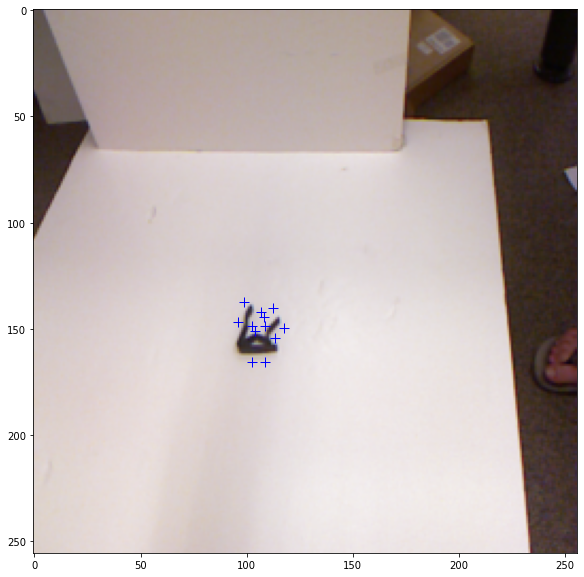

In [17]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [18]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=266, shuffle=False, collate_fn=collate_fn)

In [19]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([64, 3, 256, 256]) torch.float32
torch.Size([64, 8])


In [20]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([1562, 9])



# Create Model

In [21]:
import torch.nn as nn
import torch.nn.functional as F


In [22]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [23]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [24]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x

In [25]:
Net.__init__=__init__
Net.forward=forward

In [26]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 5,
            }

model = Net(params_model)

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)

In [28]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=5, bias=True)
)


# Define loss function

In [29]:
# transform function 
def bboxes_to_grasps(bboxes):
    # convert bbox to grasp representation -> tensor([x, y, theta, h, w])
    x = bboxes[:,0] + (bboxes[:,4] - bboxes[:,0])/2
    y = bboxes[:,1] + (bboxes[:,5] - bboxes[:,1])/2 
    theta = torch.atan((bboxes[:,3] -bboxes[:,1]) / (bboxes[:,2] -bboxes[:,0]))
    w = torch.sqrt(torch.pow((bboxes[:,2] -bboxes[:,0]), 2) + torch.pow((bboxes[:,3] -bboxes[:,1]), 2))
    h = torch.sqrt(torch.pow((bboxes[:,6] -bboxes[:,0]), 2) + torch.pow((bboxes[:,7] -bboxes[:,1]), 2))
    grasps = torch.stack((x, y, theta, h, w), 1)
    return grasps

def grasps_to_bboxes(grasps):
    # convert grasp representation to bbox
    x = grasps[:,0]
    y = grasps[:,1]
    theta = grasps[:,2]
    h = grasps[:,3]
    w = grasps[:,4]
    x1 = x -w/2*torch.cos(theta) +h/2*torch.sin(theta)
    y1 = y -w/2*torch.sin(theta) -h/2*torch.cos(theta)
    x2 = x +w/2*torch.cos(theta) +h/2*torch.sin(theta)
    y2 = y +w/2*torch.sin(theta) -h/2*torch.cos(theta)
    x3 = x +w/2*torch.cos(theta) -h/2*torch.sin(theta)
    y3 = y +w/2*torch.sin(theta) +h/2*torch.cos(theta)
    x4 = x -w/2*torch.cos(theta) -h/2*torch.sin(theta)
    y4 = y -w/2*torch.sin(theta) +h/2*torch.cos(theta)
    bboxes = torch.stack((x1, y1, x2, y2, x3, y3, x4, y4), 1)
    return bboxes
    

In [30]:
# test transform function
for img, label in train_dl:
    print(label)
    print(label.shape)
    
    grasps = bboxes_to_grasps(label)
    print(grasps)
    print(grasps.shape)
    
    x = grasps_to_bboxes(grasps)
    print(x)
    print(x.shape)
    
    y = bboxes_to_grasps(x)
    print(y)
    print(y.shape)
    
    
    break

tensor([[104.8000, 110.9424, 125.2000, 110.4091, 125.6000, 133.3333, 105.2000,
         133.8667],
        [118.0000, 131.7333, 128.4000, 117.8667, 122.4000, 109.8667, 112.0000,
         123.7333],
        [114.4000, 107.0736, 129.6000, 133.7403, 118.0000, 145.6000, 102.8000,
         118.9333],
        [110.0000, 158.9701, 136.0000, 162.6667, 137.2000, 147.7333, 111.2000,
         144.0368],
        [119.6000, 148.4395, 139.6000, 152.1728, 141.2000, 138.1333, 121.2000,
         134.4000],
        [120.8000,  90.2613, 131.2000,  92.2667, 132.4000,  81.0667, 122.0000,
          79.0613],
        [101.6000, 131.6032, 109.2000, 137.6000, 112.0000, 131.2000, 104.4000,
         125.2032],
        [135.2000, 171.0853, 136.8000, 155.2000, 130.4000, 154.1333, 128.8000,
         170.0187],
        [157.2000, 116.3381, 165.6000, 150.4000, 154.4000, 155.2000, 146.0000,
         121.1381],
        [106.8000, 176.6192, 113.6000, 132.3525, 123.2000, 134.9333, 116.4000,
         179.2000],
        [1

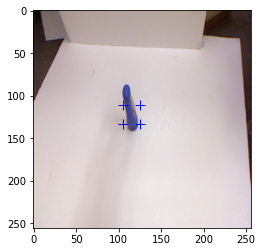

In [31]:
show(img[0], label[0])

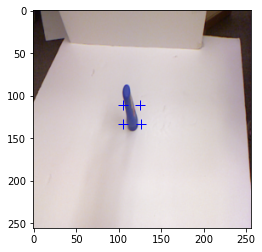

In [32]:
show(img[0], x[0])

In [33]:
import torchvision
from shapely.geometry import Polygon
from math import pi 

def box_iou(bbox_value, bbox_target):
    p1 = Polygon(bbox_value.view(-1,2).tolist())
    p2 = Polygon(bbox_target.view(-1,2).tolist())
    iou = p1.intersection(p2).area / (p1.area +p2.area -p1.intersection(p2).area) 
    return iou



def metrics_batch(output, target):
    pre_bboxes = grasps_to_bboxes(output)
    count = 0
    if target.shape[1] == 8:
        target_grasps = bboxes_to_grasps(target)  
        for i in range(len(output)):  
            iou = box_iou(pre_bboxes[i], target[i])
            pre_theta = output[i][2]
            target_theta = target_grasps[i][2]
            angle_diff = torch.abs(pre_theta - target_theta)*180/pi
            if angle_diff < 30 and iou > 0.25:
                count = count + 1
    else:
        good = [0 for i in range(len(output))]
        all_grasps = bboxes_to_grasps(target[:, 1:])
        for i in range(len(target)):
            index = target[i][0].int()
            if good[index] == 1:
                continue
            iou = box_iou(pre_bboxes[index], target[i][1:])
            pre_theta = output[index][2]
            target_theta = all_grasps[i][2]
            angle_diff = torch.abs(pre_theta - target_theta)*180/pi
            if angle_diff < 30 and iou > 0.25:
                good[index] = 1
        for flag in good:
            if flag == 1:
                count = count + 1
        
    return count

In [34]:
for img, label in train_dl:
    grasps = bboxes_to_grasps(label)
    bboxes = grasps_to_bboxes(grasps)
    print(box_iou(label[0], bboxes[0]))   
    print(metrics_batch(grasps, label))
    break

0.8256645662481638
64


In [35]:
for img, label in val_dl:
    bboxes = torch.rand(img.shape[0], 8)
    for box in label:
        bboxes[box[0].int()] = box[1:]
    grasps = bboxes_to_grasps(bboxes)
    bboxes_new = grasps_to_bboxes(grasps)
    print(box_iou(bboxes_new[0], bboxes[0]))   
    print(metrics_batch(grasps, label))
    break

0.9999991059302751
266


In [36]:

def train_loss_batch(output,targets, params_loss, opt=None):  
    mse_loss = params_loss["mse_loss"]
    gama = params_loss["gama"]
    grasps = bboxes_to_grasps(targets)
    loss_x =mse_loss(output[:,0], grasps[:,0])
    loss_y =mse_loss(output[:,1], grasps[:,1])
    loss_h =mse_loss(output[:,3], grasps[:,3])
    loss_w =mse_loss(output[:,4], grasps[:,4])
    loss_theta = mse_loss(output[:,2], grasps[:,2])
    loss = loss_x + loss_y + loss_h + loss_w + gama*loss_theta
        
    # get performance metric
    metric_b = metrics_batch(output,targets)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [37]:
a = torch.tensor([[1.0,3], [1, 1, ]])
a.mean()

tensor(1.5000)

In [38]:
def val_loss_batch(output,targets, params_loss):  
    loss = 0.0
    gama = params_loss["gama"]
    
    for index, grasp in enumerate(output):
        target = [g[1:] for g in targets if g[0].int() == index]
        target = torch.stack(target)
        target_grasps = bboxes_to_grasps(target)
        loss_x = torch.pow((target_grasps[:,0] - grasp[0]), 2).mean()
        loss_y = torch.pow((target_grasps[:,1] - grasp[1]), 2).mean()
        loss_h = torch.pow((target_grasps[:,3] - grasp[3]), 2).mean()
        loss_w = torch.pow((target_grasps[:,4] - grasp[4]), 2).mean()
        loss_theta = torch.pow((target_grasps[:,2] - grasp[2]), 2).mean()
        loss = loss + loss_x + loss_y + loss_h + loss_w + gama*loss_theta
        
    # get performance metric
    metric_b = metrics_batch(output,targets)
    

    return loss, metric_b

In [39]:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None, training=True):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        yb=yb.to(device)
        
        # get model output
        output=model(xb.to(device))
        
        # get loss per batch
        if training:
            loss_b,metric_b = train_loss_batch(output, yb, params_loss, opt)
        else:
            loss_b,metric_b = val_loss_batch(output, yb, params_loss)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        running_metric += metric_b
        
        if sanity_check:
            break

    # average loss value
    loss = running_loss/float(len_data)
    
    # average metric value
    metric = running_metric/float(len_data)
    
    return loss, metric

In [40]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)



In [41]:
# training loop
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    params_loss=params["params_loss"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,params_loss,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,params_loss,val_dl,sanity_check, training=False)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [43]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "../models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

mse_loss = nn.MSELoss(reduction="sum")

params_loss={
    "mse_loss": mse_loss,
    "gama": 5.0,
}

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist, metric_history = train_val(model,params_train)

Epoch 0/9, current lr=0.001
Copied best model weights!
train loss: 3843.289580, accuracy: 0.00
val loss: 35110.785156, accuracy: 0.00
----------
Epoch 1/9, current lr=0.001
Copied best model weights!
train loss: 3679.927706, accuracy: 0.00
val loss: 32562.951172, accuracy: 0.00
----------
Epoch 2/9, current lr=0.001
Copied best model weights!
train loss: 3447.348546, accuracy: 0.00
val loss: 28234.443359, accuracy: 0.00
----------
Epoch 3/9, current lr=0.001
Copied best model weights!
train loss: 2955.243336, accuracy: 0.00
val loss: 21636.626953, accuracy: 0.00
----------
Epoch 4/9, current lr=0.001
Copied best model weights!
train loss: 2185.787964, accuracy: 0.00
val loss: 13037.113281, accuracy: 0.00
----------
Epoch 5/9, current lr=0.001
Copied best model weights!
train loss: 1283.657411, accuracy: 0.00
val loss: 4768.774902, accuracy: 0.00
----------
Epoch 6/9, current lr=0.001
Copied best model weights!
train loss: 514.029483, accuracy: 0.00
val loss: 4130.555176, accuracy: 0.38

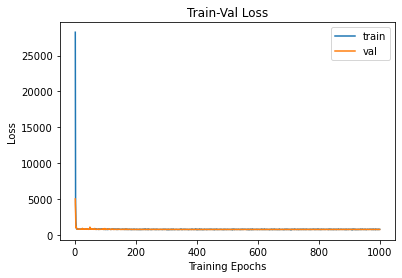

In [47]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

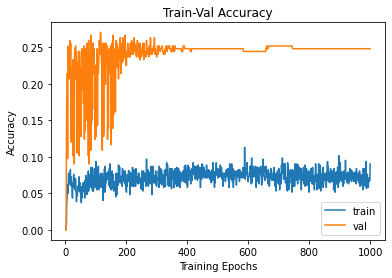

In [48]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()